The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset 

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [3]:
df.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1


**First, let's explore this dataset!**

In [4]:
df.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,36861.000000,33706.000000,33708.000000,33264.000000,31114.000000,2203.000000,565.000000,39723.000000,41396.000000
mean,6.039527,3.094612,3.319212,2.805886,2.392364,2.736723,2.249558,3.164111,0.533820
std,3.214680,1.405515,1.541307,1.580246,1.704753,1.569073,1.541283,1.523486,0.498861
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


* From this descriptive table, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. To deal with missing values, I will record them as (-1), because the missing values may reveal something about the data. This will be done in the data wrangling part. For ground service rating, because we only have 2,203 rates for this over 41,396 observations, we will not use this feature in our model.

In [5]:
len(df['airline_name'].unique()) #how many airlines operate

362

In [6]:
len(df['author_country'].unique()) #to see whether the reviews come from just some countries

159

In [7]:
df['type_traveller'].unique() #which types of travellers 

array([nan, 'FamilyLeisure', 'Couple Leisure', 'Solo Leisure', 'Business'], dtype=object)

In [8]:
df['cabin_flown'].unique() #types of cabins

array(['Economy', 'Business Class', nan, 'Premium Economy', 'First Class'], dtype=object)

In [9]:
len(df['aircraft'].unique()) #how many types of aircraft

364

In [19]:
len(df['route'].unique()) #how many routes

2209

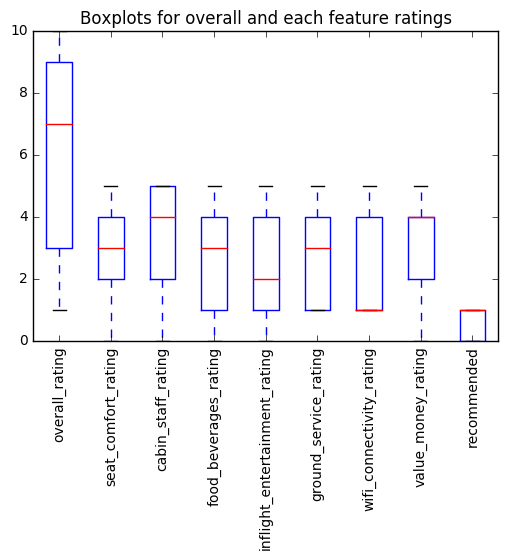

In [29]:
df.plot.box()
plt.xticks(rotation='vertical')
plt.title('Boxplots for overall and each feature ratings')
plt.show()

This box plot shows that while most feature ratings are in average of 3 to 4 on 5 star scale, the ratings for inflight entertainment and especially wifi connectivity are very low. From this finding, we may guess there is more correlation between these 2 features with overall rating (we will verify this with further analysis). Also, most airlines are recommended (value=1) and most travellers also give high rates for value-money. 

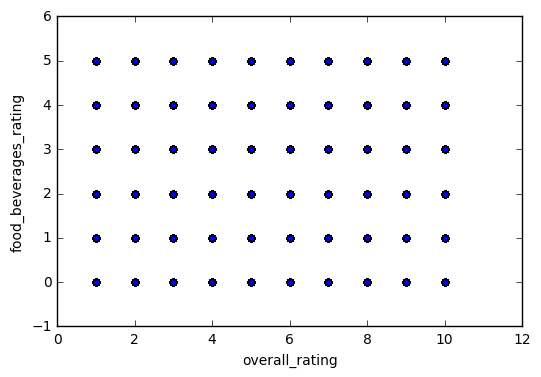

In [73]:
df_clean.plot.scatter(x='overall_rating', y='food_beverages_rating')
plt.show()

In [77]:
m = ols('overall_rating ~ seat_comfort_rating + cabin_staff_rating+food_beverages_rating+inflight_entertainment_rating+value_money_rating',df_clean).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 2.116e+04
Date:                Mon, 17 Oct 2016   Prob (F-statistic):               0.00
Time:                        19:15:56   Log-Likelihood:                -51619.
No. Observations:               28341   AIC:                         1.032e+05
Df Residuals:                   28335   BIC:                         1.033e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

**Now do some data wrangling**

In [11]:
#get rid of data points without overall rating
df_clean=df[df.overall_rating.notnull()]

In [12]:
#replacing missing values in each feature by airline with -1 since 


In [13]:
#keep the airlines with at least 50 reviews -->maybe just for rank purpose
df2=df.airline_name.value_counts()>=50



In [14]:
df2=(df.airline_name.value_counts()>=50)
df2 = df2[df2>=50].index
df.ix[df.airline_name.isin(df2)]

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended


In [15]:
df2=(df.airline_name.value_counts()>=50)
df[df.airline_name.isin(df2)]

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended


In [16]:
#rank by average overall rating
rank=df.groupby('airline_name')[['overall_rating']].mean()
rank=rank.sort_values('overall_rating', ascending=False)


In [17]:
df.date=pd.to_datetime(df.date) #change date object into datetime format

In [18]:
len(df_clean[df_clean.food_beverages_rating==0])

1787